In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("merged_dataset.csv")
df['timestamp_utc'] = pd.to_datetime(df['datetime'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   datetime       168 non-null    object             
 1   temp           168 non-null    float64            
 2   humidity       168 non-null    int64              
 3   pressure       168 non-null    int64              
 4   wind_speed     168 non-null    float64            
 5   clouds         168 non-null    int64              
 6   visibility     0 non-null      float64            
 7   weather_main   168 non-null    object             
 8   pm2_5          168 non-null    float64            
 9   pm10           168 non-null    float64            
 10  no2            168 non-null    float64            
 11  so2            168 non-null    float64            
 12  o3             168 non-null    float64            
 13  co             168 non-null    float64            

In [6]:
df.describe()

,temp,humidity,pressure,wind_speed,clouds,visibility,pm2_5,pm10,no2,so2,o3,co,aqi_index
count,168.000000,168.000000,168.000000,168.000000,168.000000,0.0,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,29.614286,68.244048,1005.017857,3.610298,49.755952,NaN,8.700476,37.522619,0.065119,0.307381,47.406964,90.103095,2.059524
std,3.326797,17.970534,2.943527,1.592503,27.742291,NaN,4.083389,21.840034,0.043154,0.206114,4.268047,2.897401,0.653891
min,24.900000,23.000000,998.000000,0.000000,5.000000,NaN,2.930000,9.990000,0.030000,0.060000,39.000000,82.720000,1.000000
25%,26.900000,58.000000,1003.000000,2.570000,20.750000,NaN,6.345000,22.550000,0.040000,0.110000,45.335000,89.347500,2.000000
50%,28.900000,76.000000,1005.000000,3.600000,40.000000,NaN,7.420000,28.950000,0.060000,0.280000,47.805000,90.925000,2.000000
75%,30.900000,83.000000,1007.000000,4.630000,75.000000,NaN,10.102500,49.160000,0.070000,0.470000,49.752500,91.642500,2.000000
max,37.900000,94.000000,1010.000000,11.830000,100.000000,NaN,21.440000,87.570000,0.430000,0.770000,59.990000,100.430000,3.000000


In [7]:
df.head()

,datetime,temp,humidity,pressure,wind_speed,clouds,visibility,weather_main,pm2_5,pm10,no2,so2,o3,co,aqi_index,timestamp_utc
0,2025-09-23 14:00:00+00:00,27.9,69,1006,5.14,75,NaN,Smoke,2.93,9.99,0.07,0.28,41.31,87.00,1,2025-09-23 14:00:00+00:00
1,2025-09-23 15:00:00+00:00,26.9,78,1006,4.63,40,NaN,Smoke,3.10,10.70,0.07,0.29,41.05,86.69,1,2025-09-23 15:00:00+00:00
2,2025-09-23 16:00:00+00:00,26.9,78,1007,4.12,40,NaN,Smoke,3.27,11.33,0.07,0.30,40.53,86.02,1,2025-09-23 16:00:00+00:00
3,2025-09-23 17:00:00+00:00,26.9,78,1007,4.63,40,NaN,Smoke,3.44,11.94,0.07,0.31,40.09,85.53,1,2025-09-23 17:00:00+00:00
4,2025-09-23 18:00:00+00:00,26.9,78,1007,5.66,40,NaN,Smoke,3.63,12.61,0.07,0.32,39.62,85.01,1,2025-09-23 18:00:00+00:00


In [8]:
MW = {
    'co': 28.01,
    'o3': 48.00,
    'no2': 46.01,
    'so2': 64.07,
}

# EPA AQI Breakpoints (updated as of 2024)
# Format: (Breakpoint Low, Breakpoint High), (AQI Low, AQI High)
BREAKPOINTS = {
    'co': [ # Unit: ppm (8-hr)
        ((0.0, 4.4), (0, 50)),
        ((4.5, 9.4), (51, 100)),
        ((9.5, 12.4), (101, 150)),
        ((12.5, 15.4), (151, 200)),
        ((15.5, 30.4), (201, 300)),
        ((30.5, 40.4), (301, 400)),
        ((40.5, 50.4), (401, 500)),
    ],
    'no2': [ # Unit: ppb (1-hr)
        ((0, 53), (0, 50)),
        ((54, 100), (51, 100)),
        ((101, 360), (101, 150)),
        ((361, 649), (151, 200)),
        ((650, 1249), (201, 300)),
        ((1250, 1649), (301, 400)),
        ((1650, 2049), (401, 500)),
    ],
    'o3': [ # Unit: ppb (8-hr)
        ((0, 54), (0, 50)),
        ((55, 70), (51, 100)),
        ((71, 85), (101, 150)),
        ((86, 105), (151, 200)),
        ((106, 200), (201, 300)),
        # Note: 8-hr Ozone AQI is not defined above 200 ppb
    ],
    'so2': [ # Unit: ppb (1-hr)
        ((0, 35), (0, 50)),
        ((36, 75), (51, 100)),
        ((76, 185), (101, 150)),
        ((186, 304), (151, 200)),
        ((305, 604), (201, 300)),
        ((605, 804), (301, 400)),
        ((805, 1004), (401, 500)),
    ],
    'pm2_5': [ # Unit: µg/m³ (24-hr)
        ((0.0, 9.0), (0, 50)),
        ((9.1, 35.4), (51, 100)),
        ((35.5, 55.4), (101, 150)),
        ((55.5, 150.4), (151, 200)),
        ((150.5, 250.4), (201, 300)),
        ((250.5, 350.4), (301, 400)),
        ((350.5, 500.4), (401, 500)),
    ],
    'pm10': [ # Unit: µg/m³ (24-hr)
        ((0, 54), (0, 50)),
        ((55, 154), (51, 100)),
        ((155, 254), (101, 150)),
        ((255, 354), (151, 200)),
        ((355, 424), (201, 300)),
        ((425, 504), (301, 400)),
        ((505, 604), (401, 500)),
    ],
}


# --- 2. Unit Conversion Functions ---

def ugm3_to_ppb(ugm3, pollutant_name):
    """Converts concentration from µg/m³ to ppb at standard conditions (25°C, 1 atm)."""
    if pollutant_name not in MW:
        return ugm3
    molecular_weight = MW[pollutant_name]
    # Molar volume at 25°C, 1 atm is 24.45 L/mol
    # Conversion: ppb = (µg/m³ * 24.45) / MolecularWeight
    return (ugm3 * 24.45) / molecular_weight

def ugm3_to_ppm(ugm3, pollutant_name):
    """Converts concentration from µg/m³ to ppm."""
    # 1 ppm = 1000 ppb
    return ugm3_to_ppb(ugm3, pollutant_name) / 1000


# --- 3. Core AQI Calculation Functions ---

def calculate_sub_index(conc, pollutant):
    """Calculates the AQI sub-index for a single pollutant."""
    
    # 1. Truncate and convert concentration to correct units
    if pollutant == 'pm2_5':
        conc = np.floor(conc * 10) / 10  # Truncate to 1 decimal
    elif pollutant == 'pm10':
        conc = np.floor(conc) # Truncate to integer
    elif pollutant == 'co':
        conc = np.floor(ugm3_to_ppm(conc, pollutant) * 10) / 10 # Truncate to 1 decimal
    elif pollutant in ['no2', 'o3', 'so2']:
        conc = np.floor(ugm3_to_ppb(conc, pollutant)) # Truncate to integer
    else:
        return np.nan # Pollutant not supported
        
    # 2. Find the correct concentration range in the breakpoints table
    for (conc_low, conc_high), (aqi_low, aqi_high) in BREAKPOINTS[pollutant]:
        if conc_low <= conc <= conc_high:
            # 3. Apply the linear interpolation formula
            # AQI = ((AQI_high - AQI_low) / (Conc_high - Conc_low)) * (Conc - Conc_low) + AQI_low
            aqi = ((aqi_high - aqi_low) / (conc_high - conc_low)) * (conc - conc_low) + aqi_low
            return round(aqi)
            
    # Handle concentrations that are "off the charts" (above 500)
    if conc > BREAKPOINTS[pollutant][-1][0][1]:
        return 500
    
    return np.nan # Should not happen if data is valid

def calculate_overall_aqi(row):
    """
    Calculates the final AQI from a row of pollutant data (in µg/m³).
    The final AQI is the *maximum* of all individual sub-indices.
    """
    pollutants = ['pm2_5', 'pm10', 'o3', 'co', 'no2', 'so2']
    sub_indices = []
    
    for p in pollutants:
        if p in row:
            sub_index = calculate_sub_index(row[p], p)
            if pd.notna(sub_index):
                sub_indices.append(sub_index)
    
    # Return the highest sub-index, or NaN if no valid data
    return max(sub_indices) if sub_indices else np.nan


# 2. Apply the AQI calculation to each row in the DataFrame
# The .apply() method runs our function on every single row
df['calculated_aqi'] = df.apply(calculate_overall_aqi, axis=1)





In [9]:
df['calculated_aqi'] = df.apply(calculate_overall_aqi, axis=1)

In [10]:
df.tail()

,datetime,temp,humidity,pressure,wind_speed,clouds,visibility,weather_main,pm2_5,pm10,no2,so2,o3,co,aqi_index,timestamp_utc,calculated_aqi
163,2025-09-30 09:00:00+00:00,35.9,41,999,5.66,40,NaN,Clouds,19.30,83.81,0.06,0.47,54.58,93.35,3,2025-09-30 09:00:00+00:00,70
164,2025-09-30 10:00:00+00:00,36.9,39,998,7.20,40,NaN,Clouds,20.02,86.52,0.06,0.47,55.68,93.95,3,2025-09-30 10:00:00+00:00,71
165,2025-09-30 11:00:00+00:00,35.9,44,998,5.14,40,NaN,Clouds,20.72,87.57,0.07,0.46,57.24,94.54,3,2025-09-30 11:00:00+00:00,73
166,2025-09-30 12:00:00+00:00,32.9,55,998,11.83,75,NaN,Clouds,21.18,87.26,0.09,0.47,58.87,95.22,3,2025-09-30 12:00:00+00:00,73
167,2025-09-30 13:00:00+00:00,28.9,79,999,4.12,100,NaN,Clouds,21.44,86.40,0.11,0.48,59.99,95.97,3,2025-09-30 13:00:00+00:00,74


In [11]:
df.describe()


,temp,humidity,pressure,wind_speed,clouds,visibility,pm2_5,pm10,no2,so2,o3,co,aqi_index,calculated_aqi
count,168.000000,168.000000,168.000000,168.000000,168.000000,0.0,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,29.614286,68.244048,1005.017857,3.610298,49.755952,NaN,8.700476,37.522619,0.065119,0.307381,47.406964,90.103095,2.059524,43.077381
std,3.326797,17.970534,2.943527,1.592503,27.742291,NaN,4.083389,21.840034,0.043154,0.206114,4.268047,2.897401,0.653891,13.771878
min,24.900000,23.000000,998.000000,0.000000,5.000000,NaN,2.930000,9.990000,0.030000,0.060000,39.000000,82.720000,1.000000,19.000000
25%,26.900000,58.000000,1003.000000,2.570000,20.750000,NaN,6.345000,22.550000,0.040000,0.110000,45.335000,89.347500,2.000000,35.000000
50%,28.900000,76.000000,1005.000000,3.600000,40.000000,NaN,7.420000,28.950000,0.060000,0.280000,47.805000,90.925000,2.000000,41.000000
75%,30.900000,83.000000,1007.000000,4.630000,75.000000,NaN,10.102500,49.160000,0.070000,0.470000,49.752500,91.642500,2.000000,53.000000
max,37.900000,94.000000,1010.000000,11.830000,100.000000,NaN,21.440000,87.570000,0.430000,0.770000,59.990000,100.430000,3.000000,74.000000


In [12]:
pollutants_to_plot = ['pm2_5', 'pm10', 'o3', 'co']
    
sns.set_style("whitegrid")

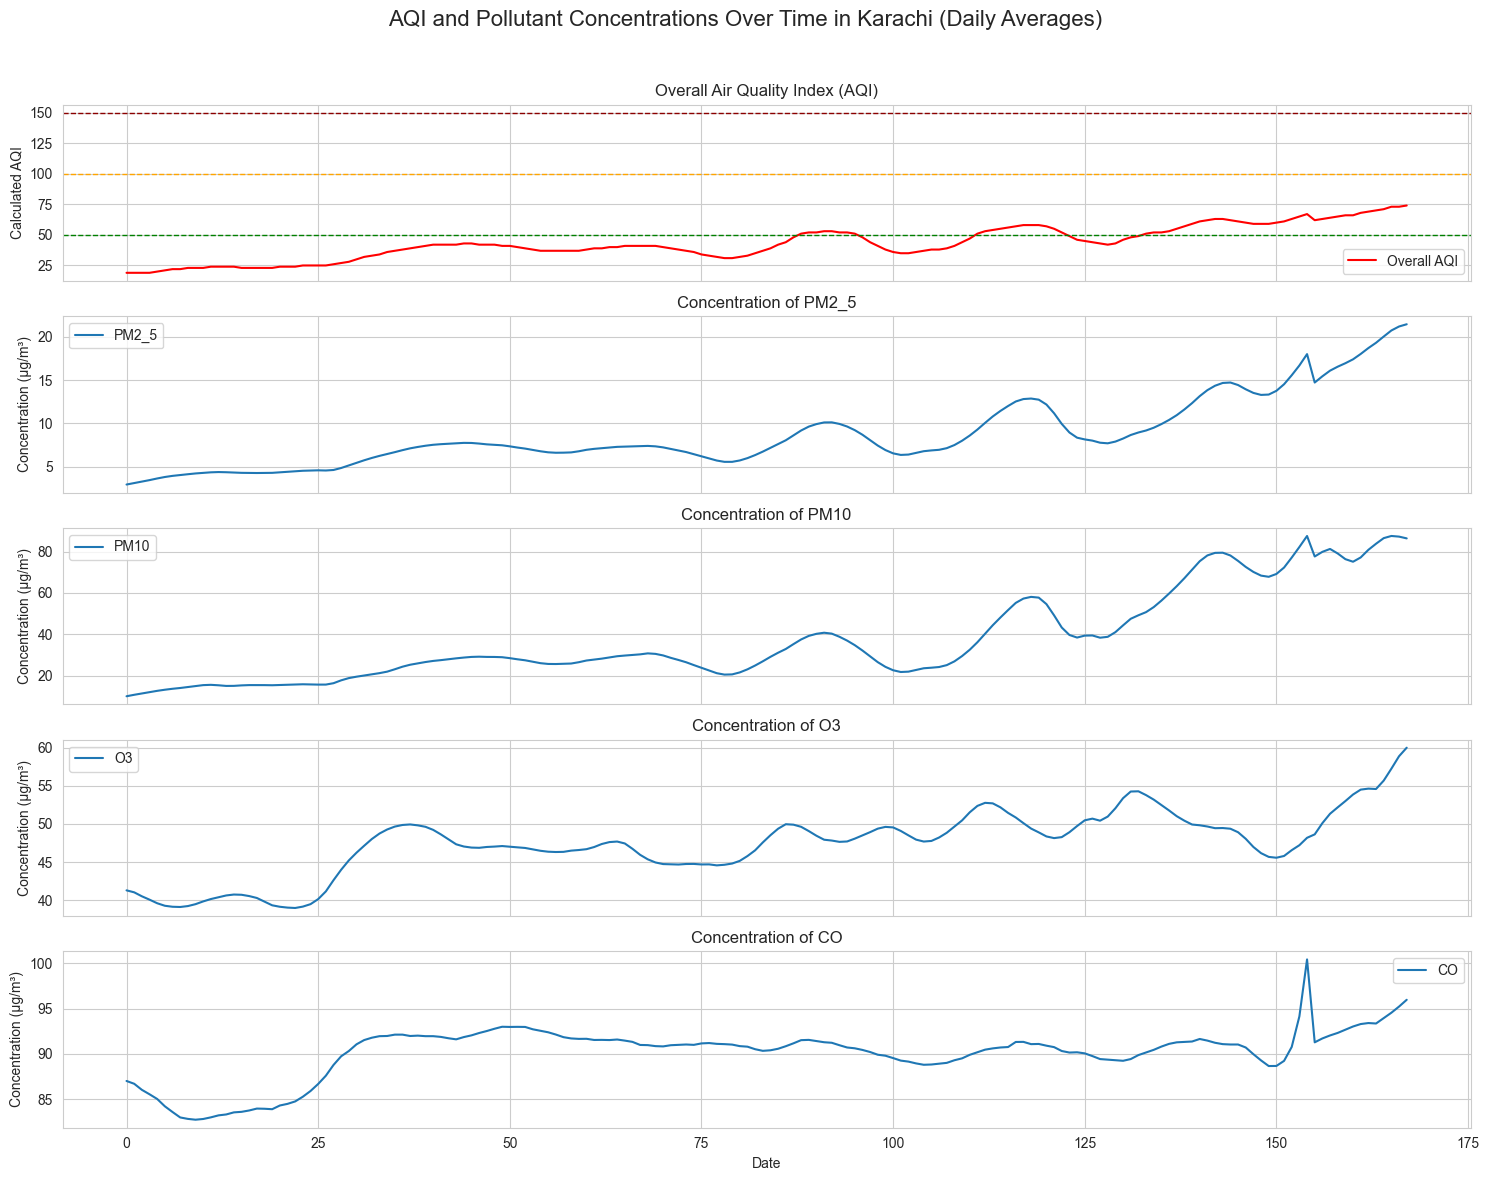

In [13]:
fig, axes = plt.subplots(len(pollutants_to_plot) + 1, 1, figsize=(15, 12), sharex=True)
    
fig.suptitle('AQI and Pollutant Concentrations Over Time in Karachi (Daily Averages)', fontsize=16)

    # 1. Plot Calculated AQI
axes[0].plot(df.index, df['calculated_aqi'], color='red', label='Overall AQI')
axes[0].set_ylabel('Calculated AQI')
axes[0].set_title('Overall Air Quality Index (AQI)')
axes[0].legend()
   
axes[0].axhline(50, color='green', linestyle='--', linewidth=1, label='Good')
axes[0].axhline(100, color='orange', linestyle='--', linewidth=1, label='Moderate')
axes[0].axhline(150, color='darkred', linestyle='--', linewidth=1, label='Unhealthy (Sensitive)')

# 2. Plot Each Pollutant on its own subplot
for i, pollutant in enumerate(pollutants_to_plot):
    ax = axes[i + 1]
    ax.plot(df.index, df[pollutant], label=pollutant.upper())
    ax.set_ylabel(f'Concentration (µg/m³)')
    ax.set_title(f'Concentration of {pollutant.upper()}')
    ax.legend()
        
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [14]:
df['hour_of_day'] = df['timestamp_utc'].dt.hour

Engineering time features...


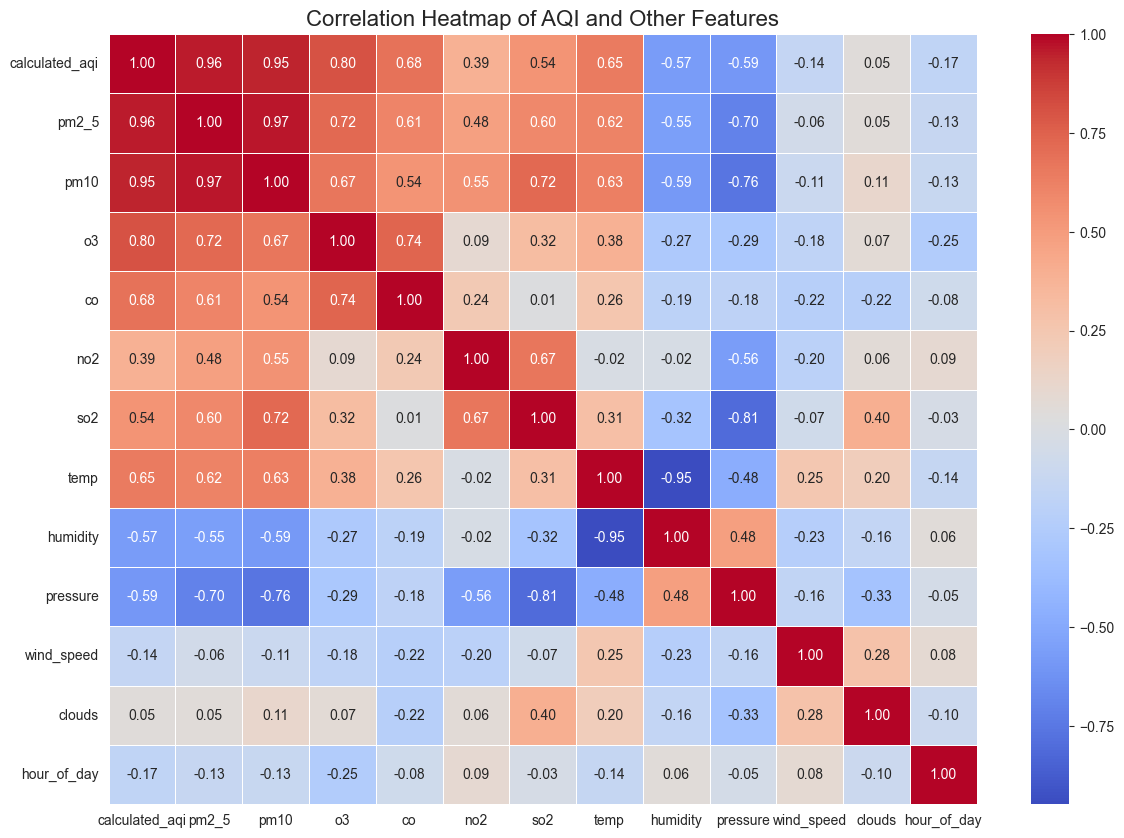

In [15]:
numerical_features = [
    'calculated_aqi', 'pm2_5', 'pm10', 'o3', 'co', 'no2', 'so2',
    'temp', 'humidity', 'pressure', 'wind_speed', 'clouds', 'hour_of_day'
]


corr_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of AQI and Other Features', fontsize=16)
plt.show()

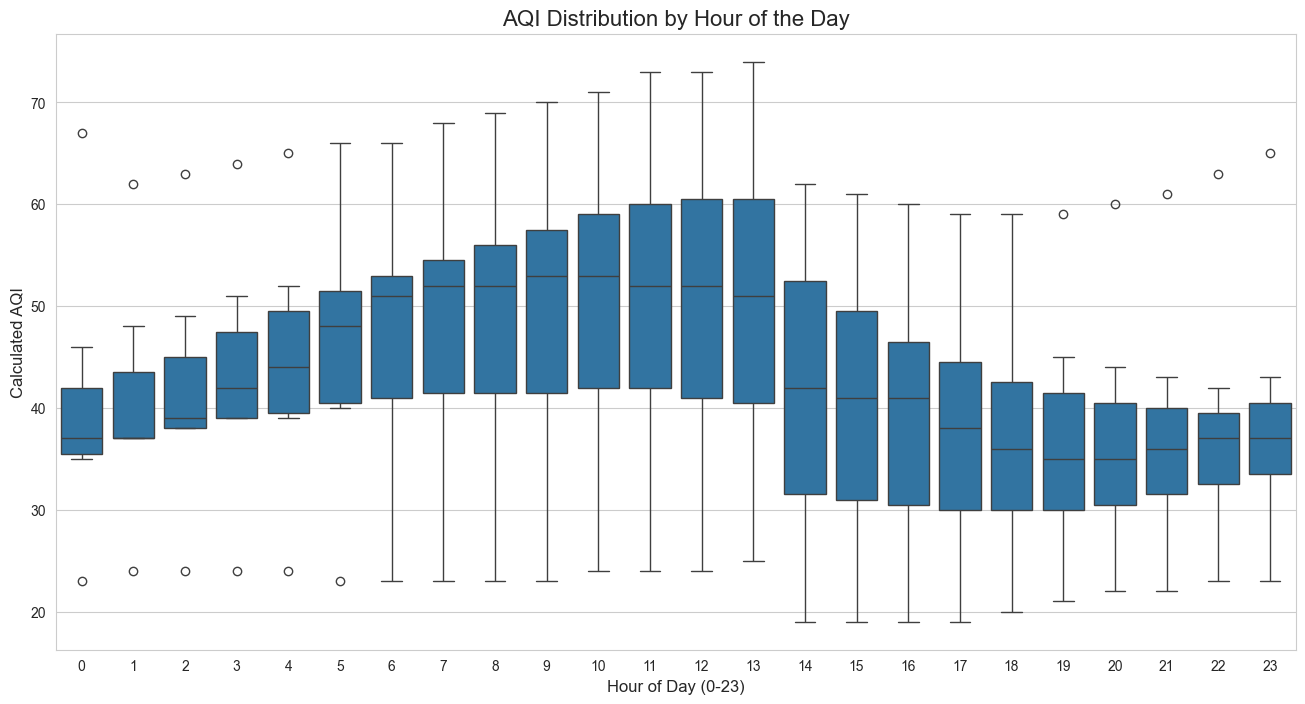

In [17]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='hour_of_day', y='calculated_aqi', data=df)
plt.title('AQI Distribution by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Calculated AQI', fontsize=12)
plt.show()

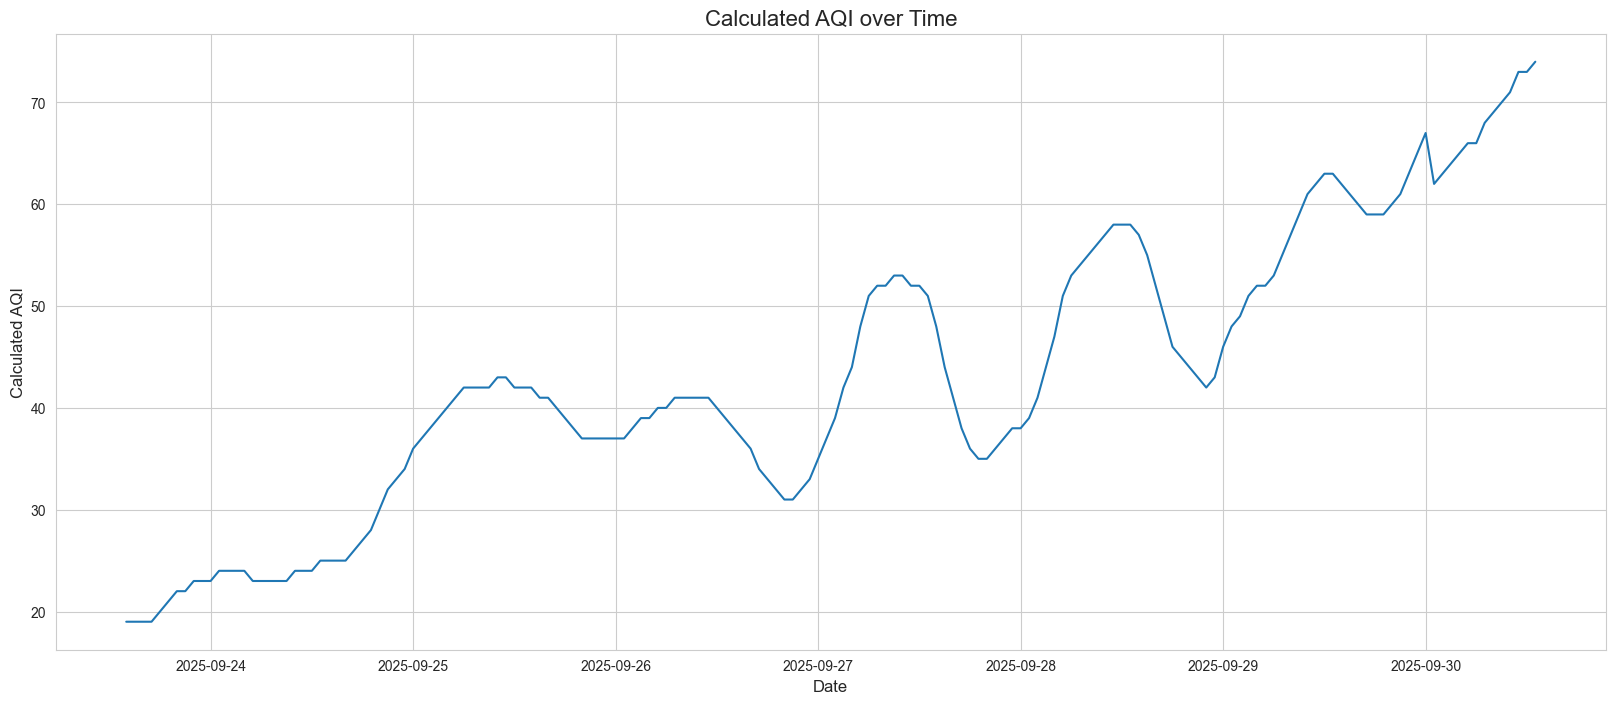

In [18]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='timestamp_utc', y='calculated_aqi', data=df)
plt.title('Calculated AQI over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Calculated AQI', fontsize=12)
plt.show()

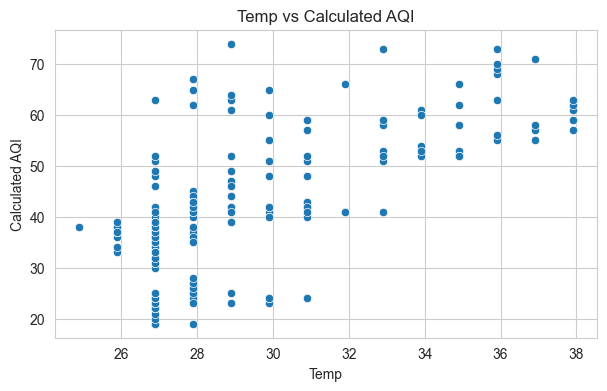

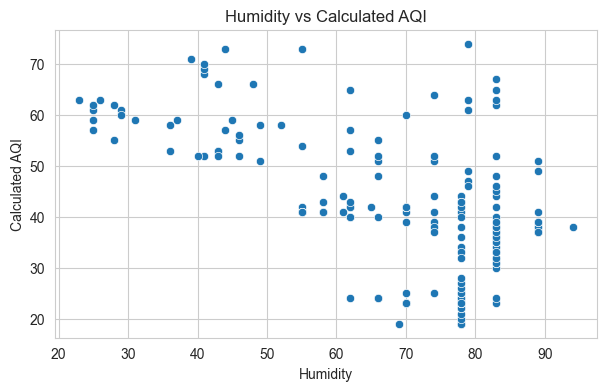

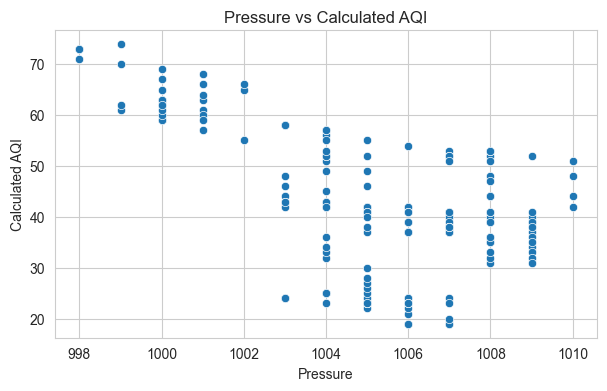

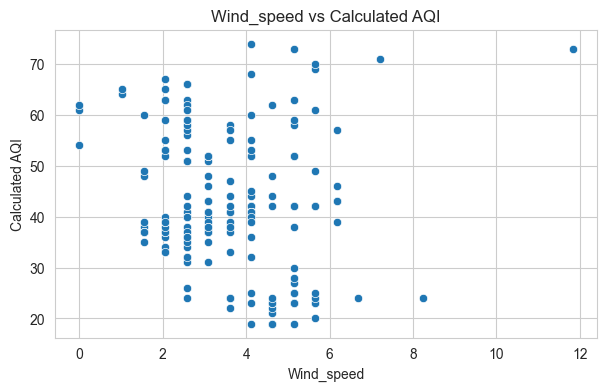

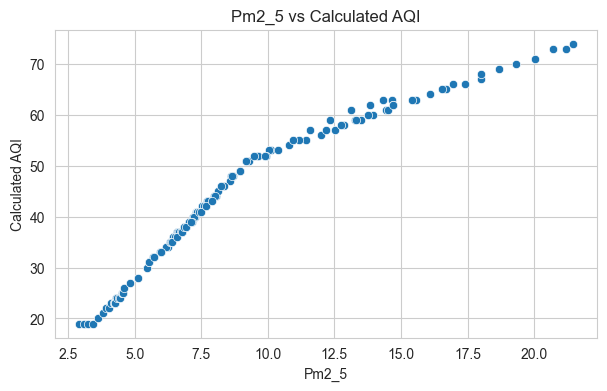

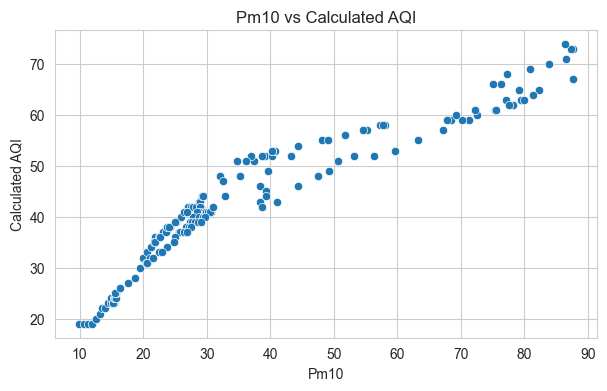

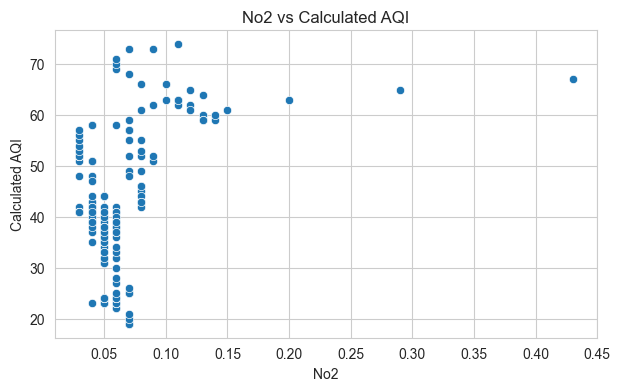

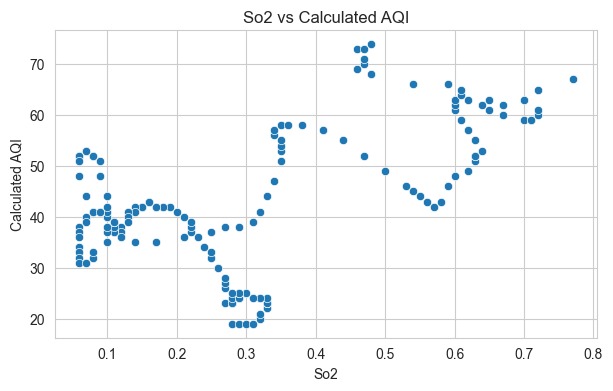

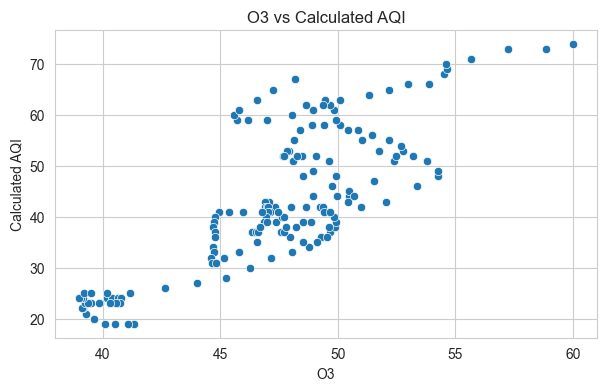

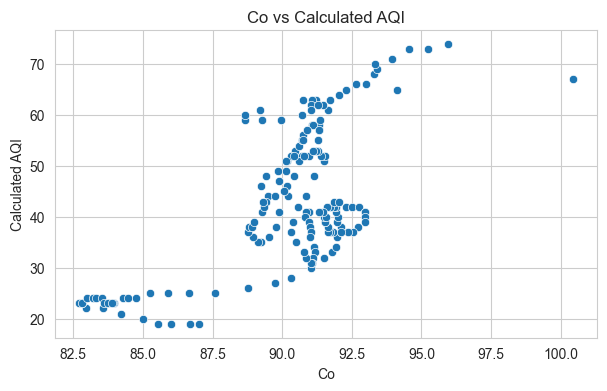

In [31]:
# WEATHER FEATURES VS AQI
numeric_features = ['temp', 'humidity', 'pressure', 'wind_speed', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'co']

for feature in numeric_features:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(x=feature, y='calculated_aqi', data=df)
    plt.title(f"{feature.capitalize()} vs Calculated AQI")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Calculated AQI")
    plt.show()

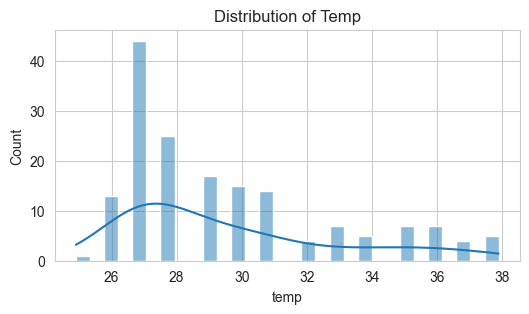

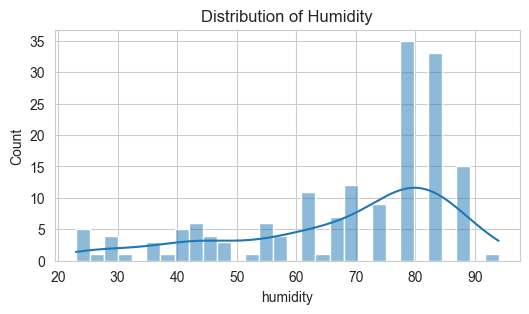

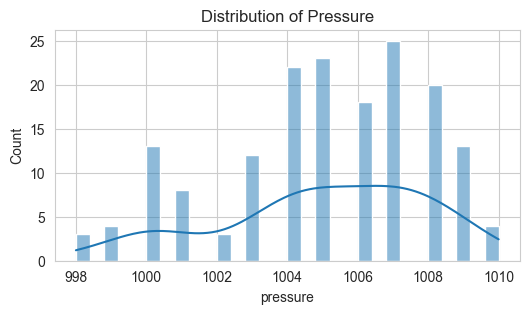

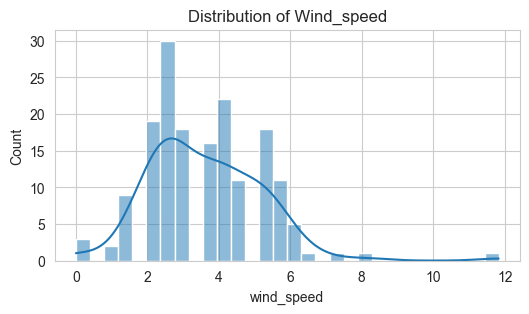

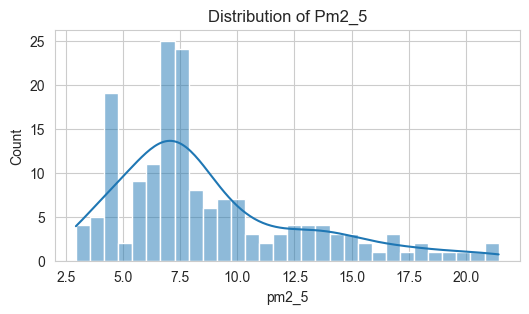

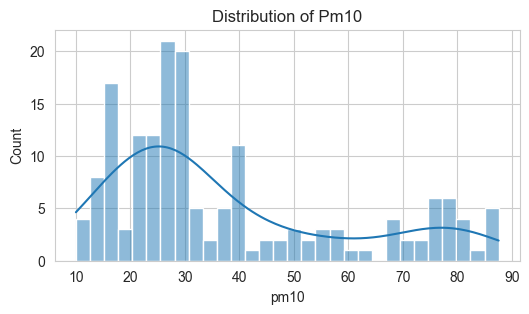

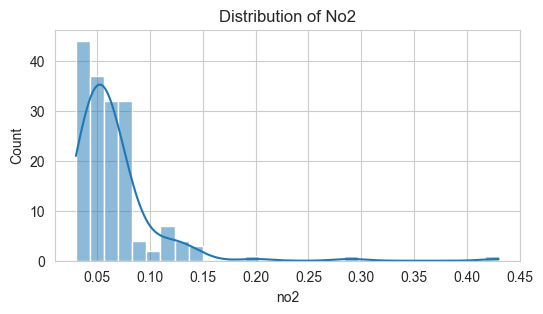

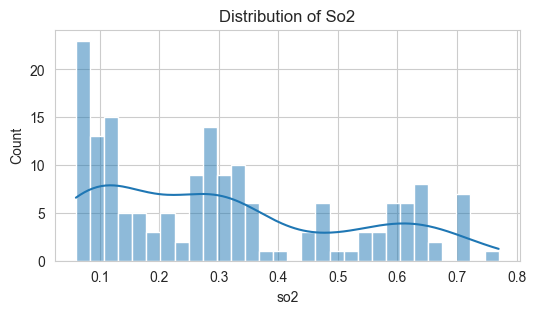

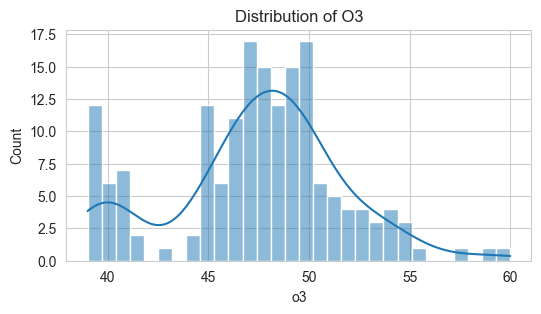

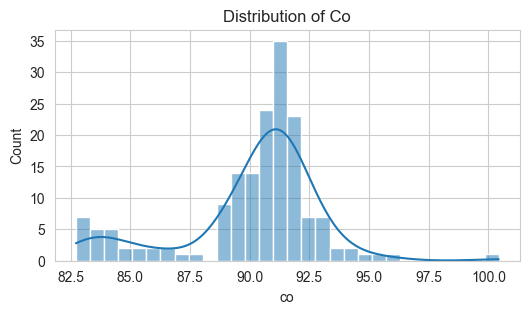

In [32]:
for feature in numeric_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature.capitalize()}")
    plt.show()

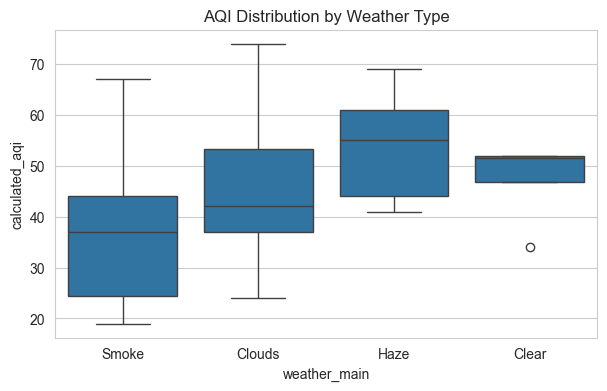

In [33]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='weather_main', y='calculated_aqi', data=df)
plt.title("AQI Distribution by Weather Type")
plt.show()

In [19]:
features = ['pm2_5',
    'pm10',
    'o3',
    'temp',
    'hour_of_day', 'calculated_aqi']

df_ml = df[features]

In [20]:
df_ml.head()

,pm2_5,pm10,o3,temp,hour_of_day,calculated_aqi
0,2.93,9.99,41.31,27.9,14,19
1,3.10,10.70,41.05,26.9,15,19
2,3.27,11.33,40.53,26.9,16,19
3,3.44,11.94,40.09,26.9,17,19
4,3.63,12.61,39.62,26.9,18,20


In [21]:
X = df_ml.drop("calculated_aqi", axis=1)
y = df_ml["calculated_aqi"]

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (134, 5)
Test set shape: (34, 5)


In [25]:
models = {
   
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),

    
    'K-Neighbors Regressor (KNN)': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor (SVR)': SVR(kernel='rbf', C=10.0),

    
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    
    y_pred = model.predict(X_test_scaled)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'R² Score': r2, 'MAE': mae, 'RMSE': rmse})


results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Evaluation Results (with Data Leakage) ---")
display(results_df)

--- Model Evaluation Results (with Data Leakage) ---


,R² Score,MAE,RMSE
Model,,,
Linear Regression,0.962318,2.200666,2.652947
Ridge Regression,0.962329,2.208305,2.652567
Lasso Regression,0.962359,2.209150,2.651486
ElasticNet,0.961607,2.257198,2.677852
K-Neighbors Regressor (KNN),0.983472,1.505882,1.757003
Support Vector Regressor (SVR),0.995965,0.672889,0.868154
Random Forest,0.999079,0.239412,0.414828
Gradient Boosting,0.999102,0.199912,0.409534


In [27]:
X_forecast = df[features]

PREDICTION_HORIZON = 3 
target_name = 'target_aqi_next_3h'
y_forecast = df['calculated_aqi'].shift(-PREDICTION_HORIZON).rename(target_name)


final_df = X_forecast.join(y_forecast, rsuffix='_target')
final_df = final_df.dropna()


X = final_df[features].drop("calculated_aqi", axis=1)
y = final_df[target_name] # This is our target column

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (132, 5)
Test set shape: (33, 5)


In [29]:
models = {

    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),

    
    'K-Neighbors Regressor (KNN)': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor (SVR)': SVR(kernel='rbf', C=10.0),

    
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
results = []
trained_models = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model # Save the trained model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'R² Score': r2, 'MAE': mae, 'RMSE': rmse})

# Display results
results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Evaluation Results (Forecasting) ---")
display(results_df.round(3))

--- Model Evaluation Results (Forecasting) ---


,R² Score,MAE,RMSE
Model,,,
Linear Regression,0.964,2.115,2.761
Ridge Regression,0.965,2.089,2.748
Lasso Regression,0.965,2.055,2.743
ElasticNet,0.965,2.015,2.745
K-Neighbors Regressor (KNN),0.985,1.352,1.790
Support Vector Regressor (SVR),0.984,1.289,1.854
Random Forest,0.984,1.298,1.850
Gradient Boosting,0.985,1.350,1.768


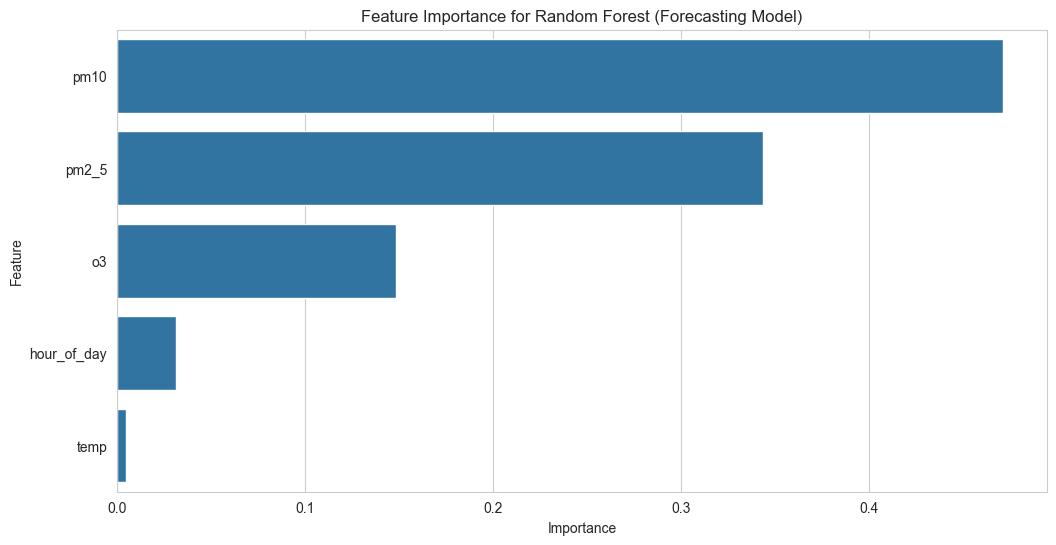

In [30]:
rf_model = trained_models['Random Forest']

# Get importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Random Forest (Forecasting Model)')
plt.show()